In [6]:
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from copy import deepcopy

In [7]:
def accept_matrix(deltaFitness, temp):
    return np.minimum(np.ones(deltaFitness.shape), np.exp(-(deltaFitness)/temp))
@jit
def accept(deltaFitness, temp):
    return np.random.uniform(0, 1) < min(1.0, math.exp(-(deltaFitness)/temp))
@jit
def set_initial_temperature(m1, m2, avgFitnessDiff, p0):
    return -avgFitnessDiff / math.log(p0)

def simulated_annealing_bootstrap(S_current, targetInitTemp, funcFitness, funcMove):
    from copy import deepcopy
    fitnessDiffSum = 0
    #bootstrapping 
    S = deepcopy(S_current)
    currentFitness = funcFitness(S)
    m1=m2=0
    for i in range(100):
        _S = funcMove(deepcopy(S))
        dE = funcFitness(_S) - currentFitness
        if dE <= 0: 
            m1+=1
            fitnessDiffSum += -dE
    print(fitnessDiffSum)
    return set_initial_temperature(m1, m2, fitnessDiffSum / m1, targetInitTemp)

def simulated_annealing(S_current, initAccept, funcFitness, funcMove):
    T = simulated_annealing_bootstrap(S_current, initAccept, funcFitness, funcMove)
    N = len(S_current)
    hasntImproved = 0
    bestFitness = funcFitness(S_current)
    sys.stdout.write("Temperature: %f; Current Fitness: %d\t\r"%(T,funcFitness(S_current)))
    sys.stdout.flush()
    while hasntImproved < 3:
        N_iter = 0
        N_accept = 0
        currentFitness = funcFitness(S_current)
        hasImproved = False
        while N_accept < 12*N and N_iter < 100*N:
            S_new = funcMove(deepcopy(S_current))
            newFitness = funcFitness(S_new)
            if accept(newFitness-currentFitness, T):
                S_current = S_new
                N_accept += 1
            if newFitness-currentFitness < 0:
                hasImproved = True
            N_iter += 1
        if not hasImproved:
            hasntImproved += 1
        else:
            hasntImproved = 0
        sys.stdout.write("Temperature: %f;  Current Fitness: %f\t\r" % (T, funcFitness(S_current)))
        sys.stdout.flush()            
        T = 0.8*T
    return S_current

In [11]:
@jit
def fitness(solution, distance):
    cost = 0
    for i in range(len(solution)-1):
        cost += distance[solution[i]][solution[i+1]]
    cost += distance[solution[-1]][solution[0]]
    return cost  

def move(solution, distance):
    first, second = int(np.random.uniform(len(solution))), int(np.random.uniform(len(solution)))
    while first == second:
        second = int(np.random.uniform(len(solution)))
    solution[first], solution[second] = solution[second], solution[first]   
    return solution

@njit
def two_opt_algorithm(solution, distance):
    change = True
    while change:
        change = False
        for i, _ in enumerate(solution[:-1]):
            for j, _ in enumerate(solution[:-1]):
                if j != i-1 and j != i and j != i+1:
                    if distance[solution[i]][solution[i+1]] + distance[solution[j]][solution[j+1]] >= distance[solution[i]][solution[j]] + distance[solution[i+1]][solution[j+1]]:
                        solution[i+1], solution[j] = solution[j], solution[i+1]
                        change = True
    return solution

def two_opt_move(solution, distance):
    id1    = list(range(len(solution)))
    id2    = list(range(len(solution)))
    np.random.shuffle(id1)
    np.random.shuffle(id2)
    S = len(solution)
    for i in id1:
        for j in id2:
            if j != i-1 and j != i and j != i+1:
                if distance[solution[i]][solution[(i+1)%S]] + distance[solution[j]][solution[(j+1)%S]] >= distance[solution[i]][solution[j]] + distance[solution[(i+1)%S]][solution[(j+1)%S]]:
                    solution[(i+1)%S], solution[j] = solution[j], solution[(i+1)%S]
    return solution

def get_travel(solution, city_points):
    travel = []
    for v in solution:
        travel.append(city_points[v])
    travel.append(city_points[solution[0]])
    return np.array(travel)

def init_tsp(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2)
    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
    return cities, distances

709.5905050859624
[1, 20, 16, 18, 23, 28, 21, 2, 4, 13, 10, 25, 0, 11, 8, 26, 9, 24, 17, 7, 5, 14, 27, 29, 12, 3, 6, 15, 22, 19]
4.456204178286104


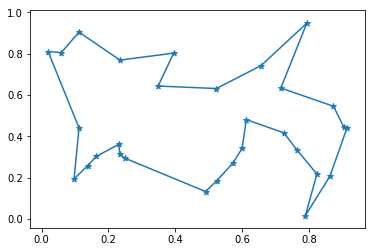

In [12]:
#%%prun -s cumulative -q -l 10 -T prun0
NB_CITIES=30
cities, distances = init_tsp(NB_CITIES)
solution=(list(range(NB_CITIES)))
np.random.shuffle(solution)
solution = simulated_annealing(solution, 0.3, lambda solution: fitness(solution, distances), lambda solution: two_opt_move(solution, distances))
print(solution)
print(fitness(solution, distances))
x, y = zip(*get_travel(solution, deepcopy(cities)))
plt.plot(x,y)
x, y = zip(*cities)
plt.scatter(x, y, marker='*') 


In [10]:
#print(open('prun0', 'r').read())

         81082693 function calls (79264498 primitive calls) in 29.811 seconds

   Ordered by: cumulative time
   List reduced from 2512 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   31.345   31.345 {built-in method builtins.exec}
        1    0.000    0.000   31.345   31.345 <string>:2(<module>)
      2/1    0.202    0.101   31.154   31.154 <ipython-input-7-cedba540b1dc>:29(simulated_annealing)
  6880499    3.935    0.000   21.748    0.000 typeof.py:25(typeof)
110940/55470    4.618    0.000   21.337    0.000 <ipython-input-8-c5b10829c2cd>:29(two_opt_move)
6880506/6880499    3.035    0.000   15.374    0.000 functools.py:819(wrapper)
  6880428    2.557    0.000    8.434    0.000 typeof.py:105(_typeof_int)
    55537    0.074    0.000    6.156    0.000 <string>:6(<lambda>)
  6880428    3.919    0.000    5.877    0.000 utils.py:300(bit_length)
    55538    0.501    0.000    5.873    0.000 <ipython-input-8